# DATASET에 있는 이미지 모두  FaceMesh Image로 변환

In [22]:
import mediapipe as mp
import numpy as np # linear algebra
import os,cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from detectFaceMeshImage import detectFaceMeshImage

import tensorflow as tf

import os
data_path = './Input/CK+48'
file_list = os.listdir(data_path)
file_list.remove('.DS_Store')

print("file list:",file_list)

#디렉토리에서 이미지를 추출하기

img_data_list=[]

img_count = 0
#우리가 파일을 만든 순서가 아닌 컴퓨터가 지가 읽는 순서대로 파일을 불러옴.
for dataset in file_list:
    img_one_cat_len = 0
    img_list=os.listdir(data_path+'/'+ dataset)
    print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
    for img in img_list:
        #이미지를 해당 경로에서 하나씩 읽어와서 (48,48)사이즈로 읽어와 img_data_list라는 array에 저장.        
        input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img )
        input_img_resize=cv2.resize(input_img,(300,300),interpolation=cv2.INTER_LINEAR)
        image = detectFaceMeshImage(input_img_resize,300)
        cv2.imwrite(f'./annotated/{dataset}/{img_one_cat_len}.jpg', image)
        img_one_cat_len +=1

file list: ['happy', 'surprise', 'sadness', 'anger']
Loaded the images of dataset-happy

Loaded the images of dataset-surprise

Loaded the images of dataset-sadness

Loaded the images of dataset-anger



# FaceMeshImage 학습돌리기

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os,cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#matplotlib을 통해 보여줄 그래프의 크기를 직접 지정해 준것.
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.utils import np_utils
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
from keras.models import Sequential
from keras.layers import *
from keras.metrics import categorical_accuracy
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
from keras.optimizers import *
import os
data_path = './annotated'
file_list = os.listdir(data_path)
# file_list.remove('.DS_Store')

print("file list:",file_list)

# Any results you write to the current directory are saved as output

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.datasets import make_classification
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from detectFaceMeshImage import detectFaceMeshImage

#디렉토리에서 이미지를 추출하기

num_epoch=10

img_data_list=[]

labels = []
labeled = 0
img_count = 0
#우리가 파일을 만든 순서가 아닌 컴퓨터가 지가 읽는 순서대로 파일을 불러옴.
for dataset in file_list:
    img_one_cat_len = 0
    img_list=os.listdir(data_path+'/'+ dataset)
    print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
    for img in img_list:
        #이미지를 해당 경로에서 하나씩 읽어와서 (48,48)사이즈로 읽어와 img_data_list라는 array에 저장.        
        input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img )
        input_img_resize=cv2.resize(input_img,(128,128),interpolation=cv2.INTER_AREA)
#         face_mesh_img = detectFaceMeshImage(input_img,128)
        img_data_list.append(input_img_resize)
        img_one_cat_len +=1
    #라벨링 넘파이 배열 생성 
    for label in range(img_one_cat_len):
        labels.append(labeled)

    labeled += 1

img_data = np.array(img_data_list)
labels = np.array(labels)

#이미지 데이터 정규화

img_data = img_data.astype('float32')
img_data = img_data/255 #normalization
print(img_data.shape)

num_classes = len(file_list)

# 카테고리 리스트로 선언
names = file_list

#라벨 이름 리턴
def getLabel(labels): 
    return names[labels.index(1)]
def getLabel_Incoding(preds):
    index = np.argmax(preds)
    return names[index-1]    

# 훈련, 검증 데이터 셋 분리.

#원핫 인코딩 /  (파라미터 값, 0으로된 배열의 크기)
# 0: 1000000
# 1: 0100000
# 2: 0010000
#하나의 이미지에 대해 0과 1로 라벨링된(원핫인코딩된)배열을 리턴받음.
Y = np_utils.to_categorical(labels, num_classes)

#Shuffle the dataset
x,y = shuffle(img_data,Y, random_state=2)
# Split the dataset
# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)

#모델 생성 및 요약
# import creat_model as cm

from create_model import create_model

model_custom = create_model()

model_custom.summary()

#Conduct k-Fold Cross-validation

from sklearn.model_selection import KFold

# kfold 교차 검증
# 데이터가 적은 데이터 셋에 대하여 정확도를 향상 시키기 위함.
# 이는 기존에 Training / Validation / Test 세개의 집단으로 분류하는것 보다 Training / Test로만 분류할때 학습 데이터 셋이 더 많기 때문.

# 5개의 폴드 세트로 분리하는 K Fold 객체와 폴드 세트별 정확도를 담을 리스트 객체 생성.
kf = KFold(n_splits=10, shuffle=False)

#Data Augmentation 기능 / 데이터 증강 기법
#모델의 성능을 높이면서 오버피팅을 극복하기 위해 학습 데이터의 다양성을 늘리기 위함.
#하나의 원본 이미지를 다양항 버전으로 만들어 학습시키는 것.
#대표적인 데이터 증강 기법으로는 원본 이미지를 수평 또는 수직 반전 시키는 방법, 회전시키는 방법, 일부를 자르는 방법,RGB채널 순서를 바꾸거나 
#픽셀값을 변경하여 원본 이미지의 색조를 변경시키는 것들이 있음.
#이러한 이미지 증강 기법을 tf.keras의 ImageDataGenerator 가 대신해줌.
#이 툴 이외에 Data Albumenation이나, ImgAug, Tensorflow Image Library 등 다양한 데이터 증강 기법 툴들이 있음.

from keras.preprocessing.image import ImageDataGenerator

# 이미지 증강법 1단계.ImageDataGenerator 객체(aug)를 생성하면서 증강을 수행할 유형들을 지정.
aug = ImageDataGenerator(
    rotation_range = 40,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest')

#Training Model 
BS = 8 # batch size
EPOCHS = 100 # epochs

result = []
scores_loss = []
scores_val_loss = []
scores_acc = []
scores_val_acc=[]
k_no = 0

#Kfold 객체의 split()을 호출하면 폴드별 학습용, 검증용 테스트의 로우 인덱스를 array로 반환
#split()이 알아서 학습용 검증용 데이터를 나누어줌. 위에서 k=5라고 지정한 경우 for문이 5번 돌아 가면서 학습용, 검증용 데이터를 나누어 줌.
for train_index, test_index in kf.split(x):
    #Kfold 객채의 split()으로 반환된 인덱스를 이용해 학습용, 검증용 테스트 데이터를 추출함.
    X_Train,X_Test = x[train_index], x[test_index]
    Y_Train,Y_Test = y[train_index], y[test_index]

    # 최적의 모델을 저장할 경로
    file_path = "./weights_best_emotion_detect3.h5"
    # 콜백 함수. (체크포인트, 조기 종료 선언)
    checkpoint = ModelCheckpoint(file_path, monitor='loss', save_best_only=True, mode='min')
    early = EarlyStopping(monitor="loss", mode="min", patience=8)

    callbacks_list = [checkpoint, early]

    #이미지 증강법 2단계 aug.flow(X,y,batch_size=,shuffle=) : X(훈련 이미지),y(라벨), 이미지를 한번에 몇개 업로드 시킬지에 대한 배치 사이즈,데이터 셔플 유무
    #flow 메소드로 생성한 객체는 Numpy Array Iterator 객체로 우리가 흔히 아는 Python Iterator처럼 loop문이나 next()함수를 사용해 Iterator 안에 데이터를 하나씩 호출 가능.

    hist = model_custom.fit_generator(aug.flow(X_Train, Y_Train), epochs=EPOCHS,validation_data=(X_Test, Y_Test), callbacks=callbacks_list)
    # model.fit(X_Train, Y_Train, batch_size=batch_size, epochs=epochs, validation_data=(X_Test, Y_Test), verbose=1)
    
    result.append(model_custom.predict(X_Test))
    scores_loss.append(hist.history['loss'])
    scores_val_loss.append(hist.history['val_loss'])
    scores_acc.append(hist.history['accuracy'])
    scores_val_acc.append(hist.history['val_accuracy'])
    k_no+=1

print(scores_loss)    
print(scores_val_loss)

file list: ['happy', 'surprise', 'sadness', 'anger']
Loaded the images of dataset-happy

Loaded the images of dataset-surprise

Loaded the images of dataset-sadness

Loaded the images of dataset-anger

(795, 128, 128, 3)
Metal device set to: Apple M1 Pro


2022-11-30 13:19:37.462472: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-30 13:19:37.463094: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        9

/var/folders/zh/v9f2b_v55ml9_yp9qr_69lk40000gn/T/ipykernel_40297/3107152336.py:166: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model_custom.fit_generator(aug.flow(X_Train, Y_Train), epochs=EPOCHS,validation_data=(X_Test, Y_Test), callbacks=callbacks_list)
2022-11-30 13:19:38.069616: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-30 13:19:38.617018: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


23/23 [==============================] - ETA: 0s - loss: 1.3668 - accuracy: 0.3552

2022-11-30 13:19:40.721078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


23/23 [==============================] - 3s 80ms/step - loss: 1.3668 - accuracy: 0.3552 - val_loss: 1.3362 - val_accuracy: 0.3500
Epoch 2/100
23/23 [==============================] - 1s 61ms/step - loss: 1.3420 - accuracy: 0.3608 - val_loss: 1.3254 - val_accuracy: 0.3500
Epoch 3/100
23/23 [==============================] - 1s 63ms/step - loss: 1.3242 - accuracy: 0.3636 - val_loss: 1.3236 - val_accuracy: 0.3500
Epoch 4/100
23/23 [==============================] - 1s 63ms/step - loss: 1.3088 - accuracy: 0.4014 - val_loss: 1.1866 - val_accuracy: 0.6500
Epoch 5/100
23/23 [==============================] - 1s 62ms/step - loss: 1.0757 - accuracy: 0.5804 - val_loss: 0.7728 - val_accuracy: 0.7875
Epoch 6/100
23/23 [==============================] - 1s 63ms/step - loss: 0.8432 - accuracy: 0.6517 - val_loss: 0.6088 - val_accuracy: 0.7125
Epoch 7/100
23/23 [==============================] - 1s 62ms/step - loss: 0.7537 - accuracy: 0.6853 - val_loss: 0.5664 - val_accuracy: 0.7625
Epoch 8/100
23/23 

23/23 [==============================] - 1s 57ms/step - loss: 0.1935 - accuracy: 0.9231 - val_loss: 0.3468 - val_accuracy: 0.9125
Epoch 59/100
23/23 [==============================] - 1s 56ms/step - loss: 0.2036 - accuracy: 0.9203 - val_loss: 0.3816 - val_accuracy: 0.9375
Epoch 60/100
23/23 [==============================] - 1s 57ms/step - loss: 0.2014 - accuracy: 0.9161 - val_loss: 0.3251 - val_accuracy: 0.9250
Epoch 61/100
23/23 [==============================] - 1s 57ms/step - loss: 0.2408 - accuracy: 0.9077 - val_loss: 0.4058 - val_accuracy: 0.9250
Epoch 62/100
23/23 [==============================] - 1s 60ms/step - loss: 0.2439 - accuracy: 0.9021 - val_loss: 0.4178 - val_accuracy: 0.9125
Epoch 63/100
23/23 [==============================] - 1s 57ms/step - loss: 0.2328 - accuracy: 0.9119 - val_loss: 0.3899 - val_accuracy: 0.9250
Epoch 64/100
23/23 [==============================] - 1s 59ms/step - loss: 0.2122 - accuracy: 0.9175 - val_loss: 0.2812 - val_accuracy: 0.9250
Epoch 65/100

2022-11-30 13:21:11.166292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/100
23/23 [==============================] - 2s 63ms/step - loss: 0.2090 - accuracy: 0.9301 - val_loss: 0.1724 - val_accuracy: 0.9500
Epoch 2/100
23/23 [==============================] - 1s 56ms/step - loss: 0.2283 - accuracy: 0.9063 - val_loss: 0.2639 - val_accuracy: 0.8875
Epoch 3/100
23/23 [==============================] - 1s 57ms/step - loss: 0.2537 - accuracy: 0.8965 - val_loss: 0.2100 - val_accuracy: 0.9125
Epoch 4/100
23/23 [==============================] - 1s 57ms/step - loss: 0.2222 - accuracy: 0.8979 - val_loss: 0.1446 - val_accuracy: 0.9500
Epoch 5/100
23/23 [==============================] - 1s 59ms/step - loss: 0.1840 - accuracy: 0.9273 - val_loss: 0.1415 - val_accuracy: 0.9375
Epoch 6/100
23/23 [==============================] - 1s 56ms/step - loss: 0.2523 - accuracy: 0.9259 - val_loss: 0.1573 - val_accuracy: 0.9625
Epoch 7/100
23/23 [==============================] - 1s 57ms/step - loss: 0.1987 - accuracy: 0.9259 - val_loss: 0.1622 - val_accuracy: 0.9375
Epoch 

Epoch 11/100
23/23 [==============================] - 1s 63ms/step - loss: 0.1403 - accuracy: 0.9510 - val_loss: 0.1152 - val_accuracy: 0.9625
Epoch 12/100
23/23 [==============================] - 1s 61ms/step - loss: 0.1068 - accuracy: 0.9650 - val_loss: 0.2006 - val_accuracy: 0.9125
Epoch 13/100
23/23 [==============================] - 1s 61ms/step - loss: 0.1667 - accuracy: 0.9441 - val_loss: 0.2050 - val_accuracy: 0.9000
Epoch 14/100
23/23 [==============================] - 1s 59ms/step - loss: 0.1342 - accuracy: 0.9524 - val_loss: 0.0999 - val_accuracy: 0.9500
Epoch 15/100
23/23 [==============================] - 1s 59ms/step - loss: 0.1477 - accuracy: 0.9455 - val_loss: 0.1135 - val_accuracy: 0.9250
Epoch 16/100
23/23 [==============================] - 1s 59ms/step - loss: 0.1873 - accuracy: 0.9399 - val_loss: 0.1312 - val_accuracy: 0.9375
Epoch 17/100
23/23 [==============================] - 1s 61ms/step - loss: 0.1777 - accuracy: 0.9385 - val_loss: 0.1707 - val_accuracy: 0.9250

23/23 [==============================] - 1s 61ms/step - loss: 0.0983 - accuracy: 0.9651 - val_loss: 0.1134 - val_accuracy: 0.9747
Epoch 6/100
23/23 [==============================] - 1s 57ms/step - loss: 0.1075 - accuracy: 0.9623 - val_loss: 0.0636 - val_accuracy: 0.9747
Epoch 7/100
23/23 [==============================] - 1s 59ms/step - loss: 0.1185 - accuracy: 0.9581 - val_loss: 0.0642 - val_accuracy: 0.9747
Epoch 8/100
23/23 [==============================] - 1s 59ms/step - loss: 0.1397 - accuracy: 0.9553 - val_loss: 0.0890 - val_accuracy: 0.9747
Epoch 9/100
23/23 [==============================] - 1s 57ms/step - loss: 0.1153 - accuracy: 0.9637 - val_loss: 0.1994 - val_accuracy: 0.9367
Epoch 10/100
23/23 [==============================] - 1s 59ms/step - loss: 0.1201 - accuracy: 0.9595 - val_loss: 0.1405 - val_accuracy: 0.9494
Epoch 11/100
23/23 [==============================] - 1s 58ms/step - loss: 0.1087 - accuracy: 0.9595 - val_loss: 0.0712 - val_accuracy: 0.9873
Epoch 12/100
23/

<function matplotlib.pyplot.show(close=None, block=None)>

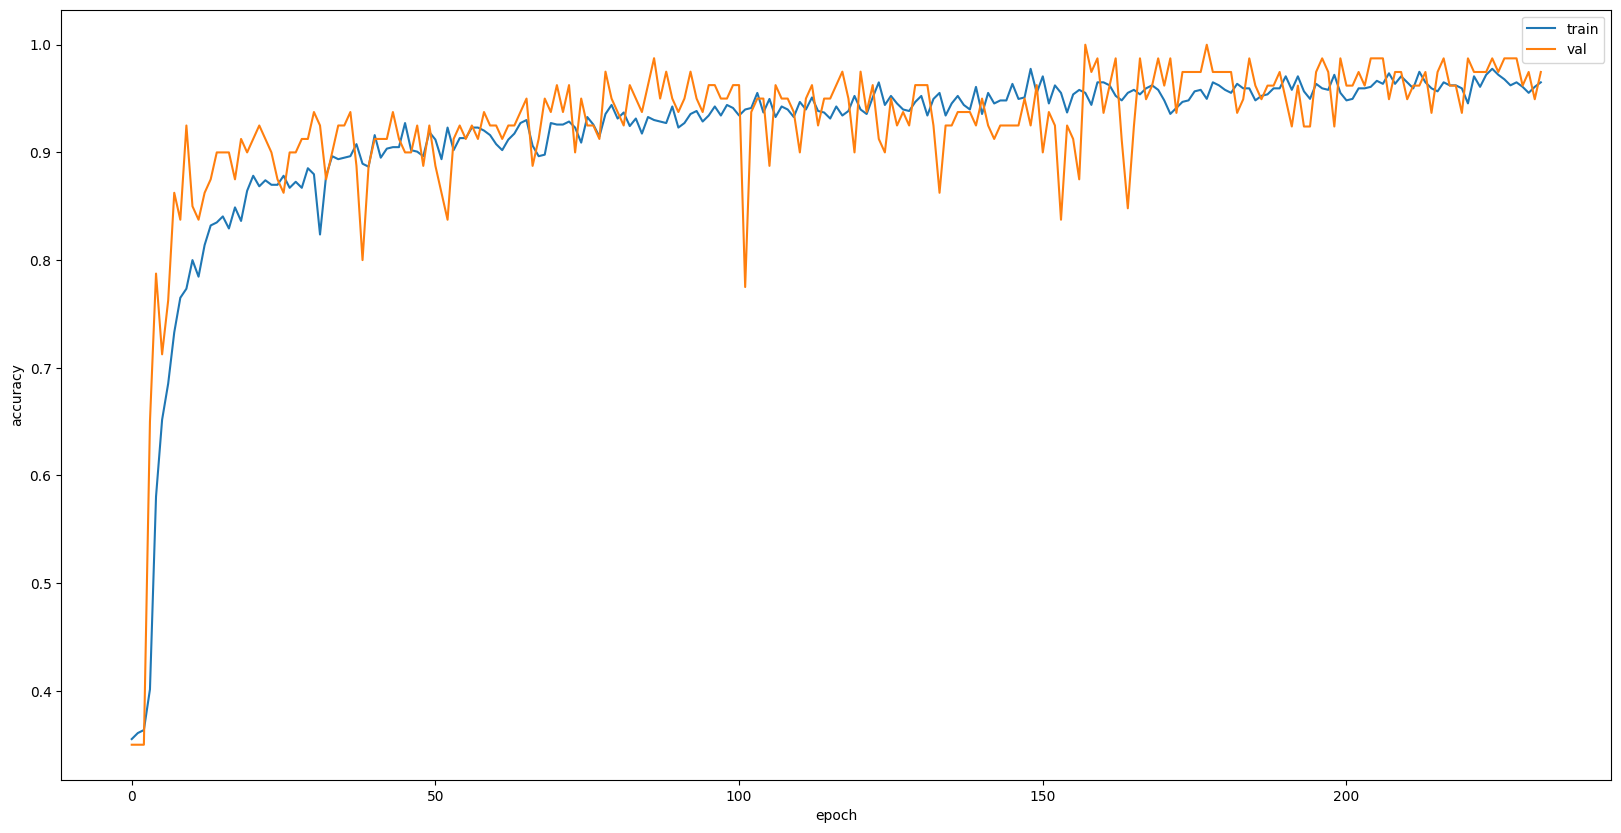

In [2]:
acc = []
val_acc = []
for i in scores_acc:
    for j in i:
        acc.append(j)        
for i in scores_val_acc:
    for j in i:
        val_acc.append(j)

plt.plot(acc)
plt.plot(val_acc)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','val'])
plt.show


25/25 [==============================] - 0s 16ms/step
[[222   1   0   0]
 [  0 286   2   1]
 [  0   0  91   1]
 [  0   1  10 180]]


<AxesSubplot: title={'center': 'confusion matrix'}>

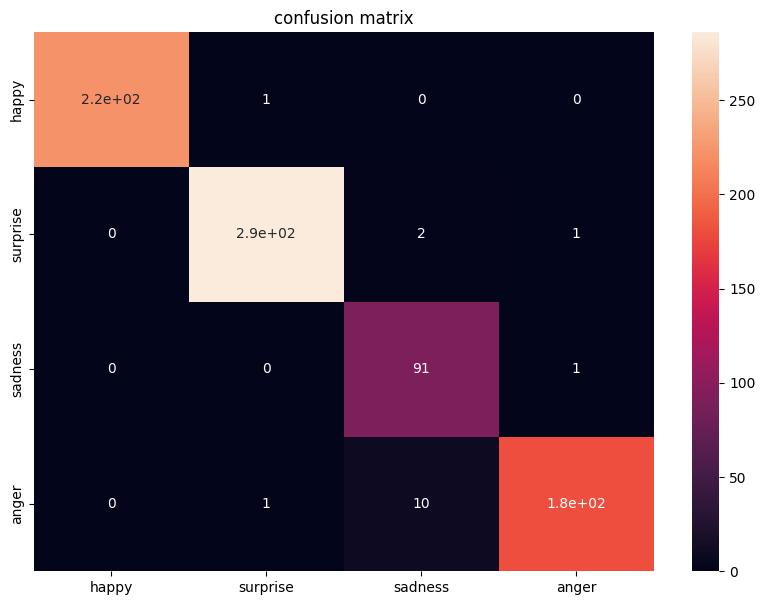

In [3]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

preds = model_custom.predict(img_data)
predicts = []
for i in preds:
    predicts.append(np.argmax(i))

print(confusion_matrix(predicts,labels))

names
cm = pd.DataFrame(confusion_matrix(predicts,labels),
                  index = [i for i in names],
                  columns = [i for i in names])
plt.figure(figsize=(10,7))
plt.title('confusion matrix')
sns.heatmap(cm,annot=True)

In [17]:
# surprise
# img = cv2.imread('./Input/CK+48/surprise/croped_image190.jpg')
# img = cv2.imread('./Input/CK+48/surprise/croped_image76.jpg')
#sadness #얘는 구분됨.
# img = cv2.imread('./Input/CK+48/sadness/croped_image456.jpg')
# img = cv2.imread('./Input/CK+48/sadness/croped_image418.jpg')
#happy
img = cv2.imread('./Input/CK+48/happy/croped_image494.jpg')
# img = cv2.imread('./Input/CK+48/happy/S010_006_00000013.png')

#anger
# img = cv2.imread('./Input/CK+48/anger/croped_image114.jpg')
# img =cv2.resize(img,(300,300),interpolation=cv2.INTER_LINEAR)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# resize_img = cv2.resize(img,(128,128),cv2.INTER_AREA)
from detectFaceMeshImage import detectFaceMeshImage
resize_img = detectFaceMeshImage(img,128)
preds= model_custom.predict(resize_img.reshape(-1,128,128,3))
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# preds = model_custom.predict(cv2.resize(img_list[0:1],(300,300),interpolation=cv2.INTER_LINEAR))
# img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
# img.reshape(-1,300,300,1)
# img.shape

preds

1/1 [==============================] - 0s 55ms/step


array([[0., 1., 0., 0.]], dtype=float32)

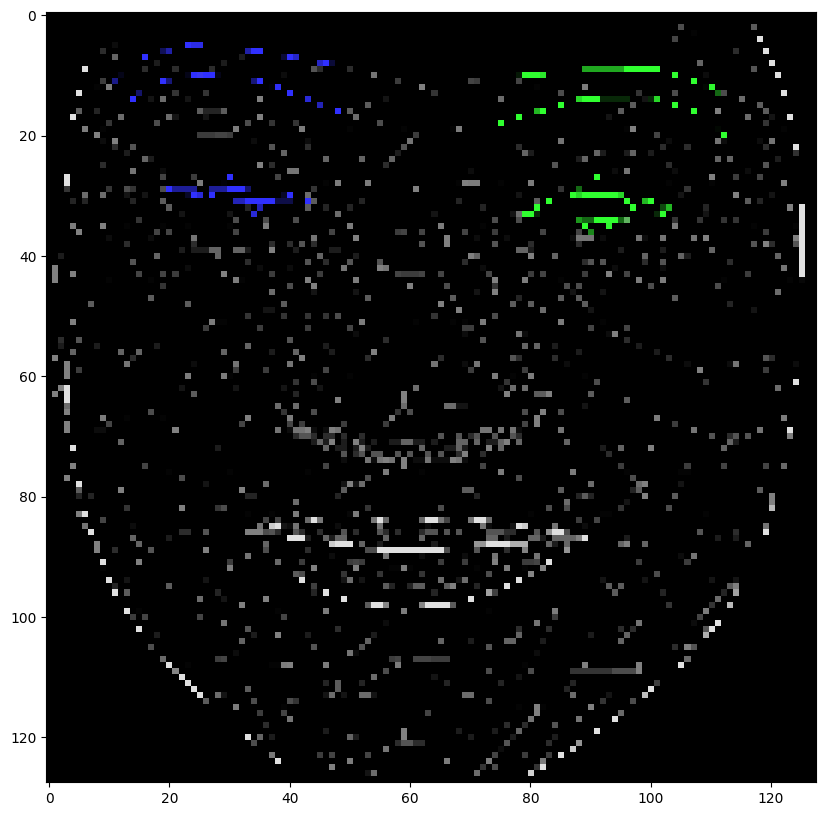

In [18]:
plt.imshow(resize_img)